In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import re
from lmfit.models import ExpressionModel
from lmfit import Model

path = '/Users/adesanmiadeniyi/Downloads/'
file_name = '20230923_EMnO2_ED_AA03_1MZnSO4_0pt2C_01_02_GCPL_C04.mpt'
path_filename = path+file_name

def cycle_life_vs_cap_plot(path, file_name):
    # Open the file in read mode
    with open(path + file_name, 'r', encoding='ISO-8859-1') as file:
    # Skip the first line
        file.readline()
    # Read and print the second line
        second_line = file.readline()
    # Search for one or more digits in the string
    match = re.search(r'(\d+)', second_line)
    if match:
        # If a match is found, convert the matched string to an integer
        header_lines = int(match.group(1))
    else:
        print("No integer value found in the second line of the mpt file")

    df= pd.read_csv(path_filename, sep ="\t", encoding= 'latin1', skiprows=(header_lines-1))  
    df["half cycle"] = df["half cycle"].astype(int)
    h_c = max(df['half cycle'])

    discharge_cap=[]
    charge_cap=[]
    cycle_number=[]
    discharge_voltage = []
    discharge_obj = []
    charge_voltage = []
    charge_obj = []

    cycle_i=df[(df['half cycle'] == 0)]
    cycle_i=cycle_i[['Capacity/mA.h','Ewe/V']].dropna()
    discharge_cap.append(cycle_i['Capacity/mA.h'].iloc[-1])

    for i in range(2, (h_c+1)):
        cycle_i=df[(df['half cycle'] == i)]
        cycle_i=cycle_i[['Capacity/mA.h','Ewe/V']] #export cycle_i to text file to obtain every half cycle

        if (i % 2 == 0):
            charge_cap.append(cycle_i['Capacity/mA.h'].iloc[-1])
            volt = []
            charge_cap_i = []
            charge_cap_i.append(cycle_i['Capacity/mA.h'])
            volt.append(cycle_i['Ewe/V'])
            charge_obj.append(charge_cap_i)
            charge_voltage.append(volt)
            
        else:
            discharge_cap.append(cycle_i['Capacity/mA.h'].iloc[-1])
            volt = []
            discharge_cap_i = []
            discharge_cap_i.append(cycle_i['Capacity/mA.h'])
            volt.append(cycle_i['Ewe/V'])
            discharge_obj.append(discharge_cap_i)
            discharge_voltage.append(volt)  

    for i in range(len(charge_cap)):
        cycle_number.append(i+1)
    
    # if the length of discharge capacity is more than the length of charge capacity, last element of the discharge capacity list has to be removed    
    if (len(discharge_cap) != len(charge_cap)):
        discharge_cap.pop()
    
    coulombic_eff = [100*i / j for i,j in zip(charge_cap, discharge_cap)]

    mass_loading = 5.83
    norm_discharge_cap = [x / mass_loading for x in discharge_cap]
    norm_charge_cap = [x / mass_loading for x in charge_cap]

    for i in range(len(discharge_obj)):
       discharge_obj[i] = np.array(discharge_obj[i])
       charge_voltage[i] = np.array(charge_voltage[i])
       charge_obj[i] = np.array(charge_obj[i])
       discharge_voltage[i] = np.array(discharge_voltage[i])

    cycle_number = np.array(cycle_number)
    discharge_cap = np.array(discharge_cap)

    #plotting cycle number against capacity
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(11,7))
    fig.tight_layout(pad=3.6)
    ax1.set_title('file_name[:-4]', fontsize = '20')
    ax1.scatter(cycle_number, norm_discharge_cap, color='r', label = 'discharge capacity')
    ax1.scatter(cycle_number, norm_charge_cap, color='b', label = 'charge capacity' )
    ax1.set_title('Capacity vs. Cycle Number with Fitted Curve')
    ax1.set_xlabel('Cycle Number', fontsize = '20')
    ax1.set_ylabel('Capacity per mg(mAh/mg)', fontsize = '20')
    ax1.set_ylim(0, max(max(norm_discharge_cap), max(norm_charge_cap)) * 1.2)
    ax2 = ax1.twinx()
    plt.rc('legend', fontsize=20)
    ax2.scatter(cycle_number, coulombic_eff, color='g', label = 'coulombic efficiency')
    ax2.set_ylim(0, max(coulombic_eff) * 1.1)
    ax2.set_ylabel('Coulombic Efficiency(%)', fontsize = '20', color='green')


    #Plotting voltage against capacity
    plt.figure()
    for i in range(len(discharge_obj)):
        plt.scatter(discharge_voltage[i], discharge_obj[i], linestyle='-')
        plt.scatter(charge_voltage[i], charge_obj[i], linestyle='-')

    #plt.plot(specific_capacity, voltage, linestyle='-')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Capacity')
    plt.title('Capacity vs. Voltage')
    plt.grid(True)
    plt.show()

    #Fitting (Predicting cycle life)
    def f_biquad(x, a0, a1, a2, a3, a4):
        return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4 

    par, cov = curve_fit(f_biquad,cycle_number,discharge_cap) 

    #Evaluate the model performance
    res = discharge_cap-f_biquad(cycle_number, *par)
    #SSE
    sse = sum(res**2)
    #SST
    sst = sum((discharge_cap-np.mean(discharge_cap))**2)
    r_sq = 1-(sse/sst)
    print('y = {:.2f}+{:.2f}x'.format(par[0],par[1]))
    print('R2 Coefficient of determination', r_sq)

    plt.subplots(nrows=1, ncols=1, figsize=(11,7))
    plt.tight_layout(pad=3.6)
    plt.plot(cycle_number, discharge_cap, 'bo', cycle_number, f_biquad(cycle_number, *par), 'r')
    plt.title('Capacity vs. Cycle Number with Fitted Curve')
    # #plt.scatter(cycle_number, norm_charge_cap, color='b', label = 'charge capacity')
    plt.xlabel('Cycle Number', fontsize = '20')
    plt.ylabel('Discharge Capacity (mAh)', fontsize = '20')
    plt.ylim(0, max(max(discharge_cap), max(charge_cap)) * 1.2)
    plt.legend(loc = 'lower right', fontsize = '20')
   #plt.savefig('Lml1.png')
    plt.show()
    target_cycle_number = 30
    predicted_capacity = f_biquad(target_cycle_number, *par)
    print(f'Predicted discharge capacity at 30th cycle: {predicted_capacity}')


#EIS: Nyquist plot
path = '/Users/adesanmiadeniyi/Downloads/'
file_name2 = 'EIS_before10pulses_C01.mpt'
path_filename2 = path+file_name2

def nyquist_plot(path, file_name2):
    with open(path + file_name2, 'r', encoding='ISO-8859-1') as file:
    # Skip the first line
        file.readline()
    # Read and print the second line
        second_line = file.readline()
    match = re.search(r'(\d+)', second_line)
    if match:
        # If a match is found, convert the matched string to an integer
        header_lines = int(match.group(1))
    else:
        print("No integer value found in the second line of the mpt file")

    df= pd.read_csv(path_filename2, sep ="\t", encoding= 'latin1', skiprows=(header_lines-1)) 

    zohm = df['-Im(Z)/Ohm'] #yaxis
    z_ohm = df['|Z|/Ohm']   #xaxis
    freq = df['freq/Hz']

    Z = z_ohm + zohm*1j
    Z_abs = np.sqrt(z_ohm*z_ohm+zohm*zohm)
    logx = np.logspace(0, 6, 10001)
    fig = plt.figure(figsize=(10,4), dpi=150)
    plt.scatter(Z.values.real, Z.values.imag, edgecolor='black', facecolor='None', marker='D', label='Sample')

    def RCcircuit(f, *params):    
        Rs = params[0]
        Rc1 = params[1]
        Q1 = params[2]
        n1 = params[3]
        
        omega = 2 * np.pi * f
        Zc1 = 1 + (np.power((1j*omega), n1)*Rc1*Q1)
        Z = Rs + (Rc1/Zc1)
        Z_abs = np.sqrt(z_ohm*z_ohm + zohm*zohm)
        return Z_abs
    
    def plot(f, *params):    
        Rs = params[0]
        Rc1 = params[1]
        Q1 = params[2]
        n1 = params[3]
        
        omega = 2 * np.pi * f
        Zc1 = 1 + (np.power((1j*omega), n1)*Rc1*Q1)
        Z = Rs + (Rc1/Zc1)
        return z_ohm, zohm
    
    init = [10, 1000, 1.0E-11, 0.9]

    #bounds for each parameters
    low = [0, 0, 0, 0]
    high = [1.0E+11, 1.0E+11, 1.0E+11, 1]
    
    popt, pcov = curve_fit(RCcircuit, freq, Z_abs, p0=init, bounds=(low,high))
    print(popt)

    param_name = ['Rs', 'Rc1', 'Q1', 'n1']
    for i, j in zip(param_name, popt.astype(np.float32)):
        print(i+' = {:E}'.format(j))
    logx = np.logspace(0, 6, 10001)
    fit = plot(logx, *popt)

    #Plotting the Nyquist plot
    print('NYQUIST PLOT')
    plt.figure()
    plt.scatter(Z.values.real, Z.values.imag, edgecolor='blue', marker='D', label='Data')
    plt.plot(fit[0], fit[1], lw=2, c='black', label='Fit')
    plt.xlabel('Z (ohm)')
    plt.ylabel('-Z (ohm)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(fontsize=12)
    plt.title('EIS Nyquist Plot')
    plt.show()

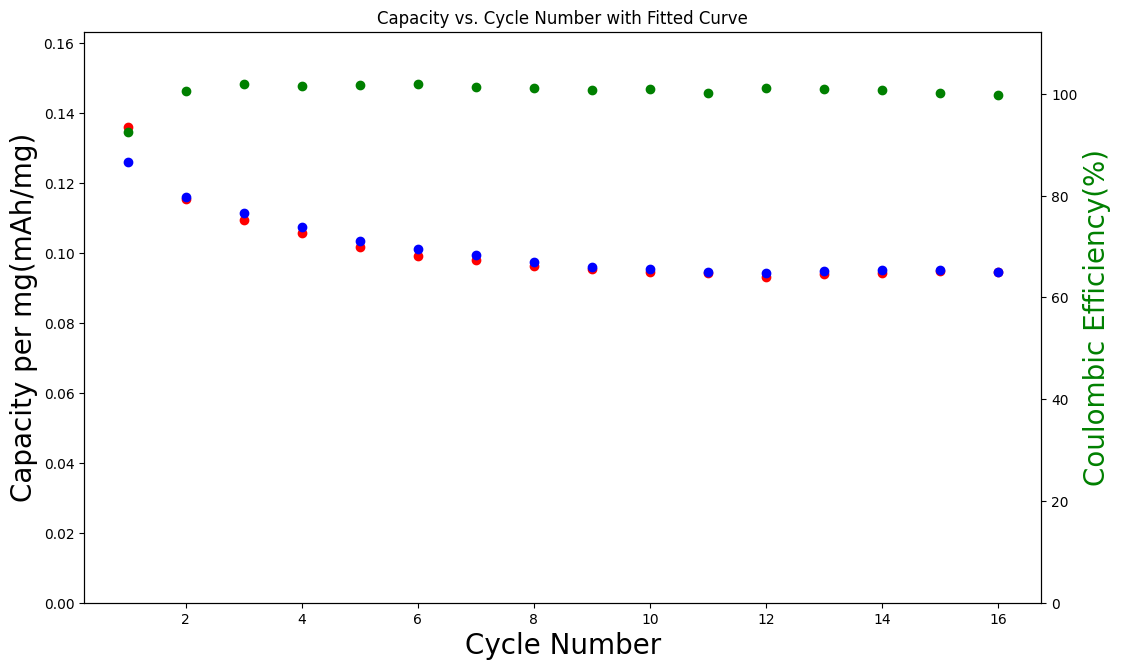

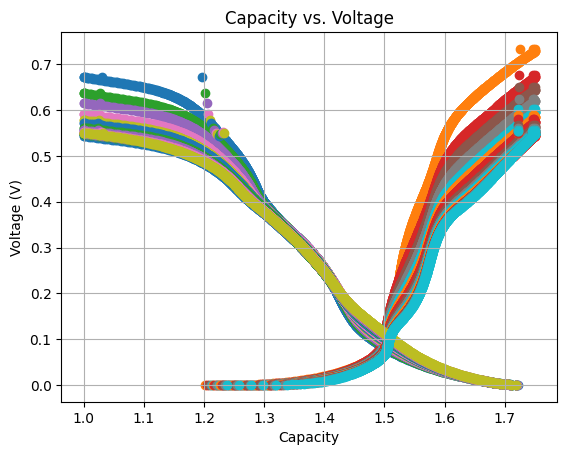

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


y = 0.89+-0.13x
R2 Coefficient of determination 0.9796120026283114


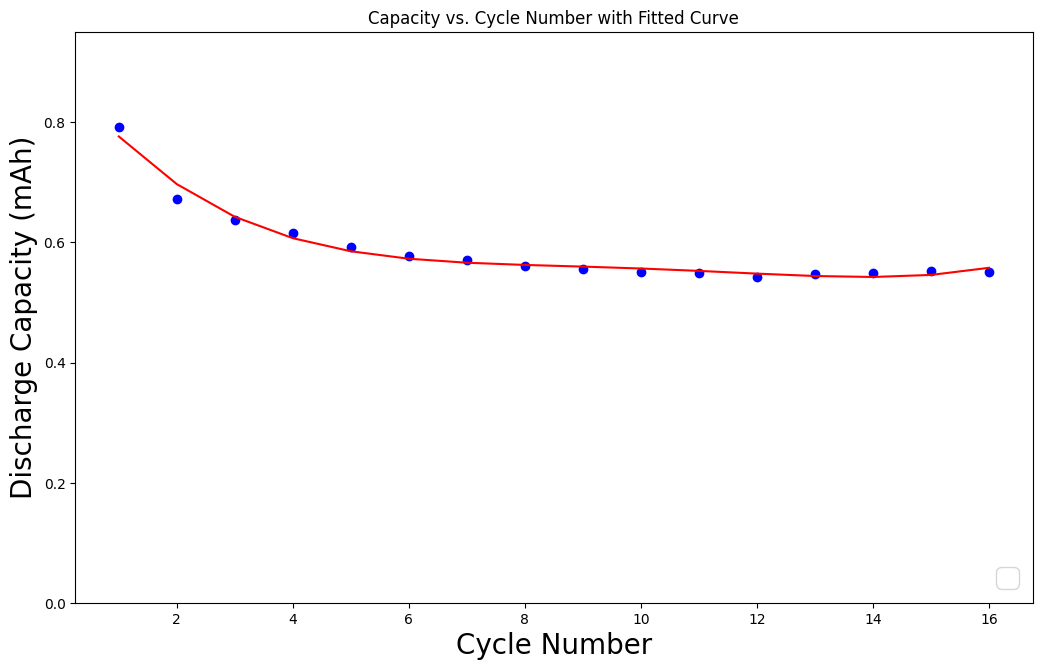

Predicted discharge capacity at 30th cycle: 5.38432598527848


In [ ]:
cycle_life_vs_cap_plot(path, '20230923_EMnO2_ED_AA03_1MZnSO4_0pt2C_01_02_GCPL_C04.mpt')

[1.e+01 1.e+03 1.e-10 9.e-01]
Rs = 1.000000E+01
Rc1 = 1.000000E+03
Q1 = 1.000000E-10
n1 = 9.000000E-01
NYQUIST PLOT


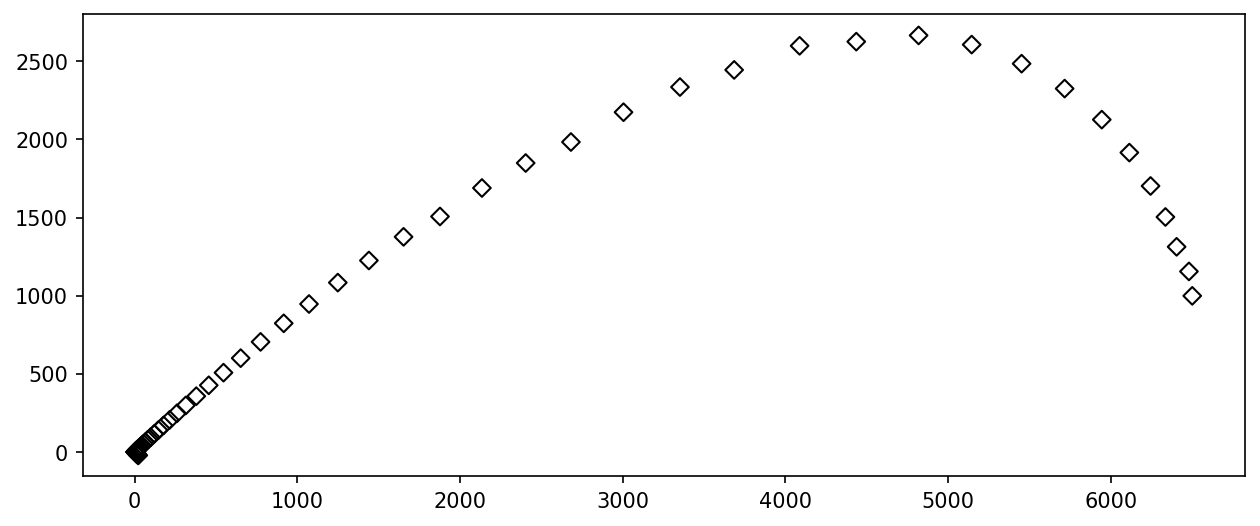

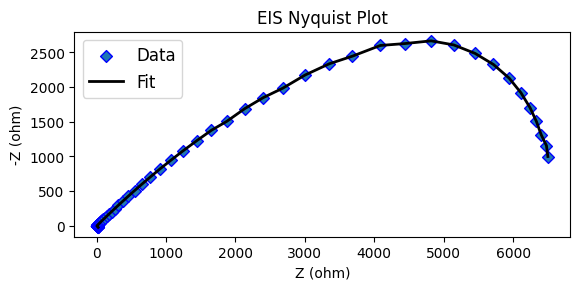

In [ ]:
nyquist_plot(path, 'EIS_before10pulses_C01.mpt')